In [25]:
import numpy as np
from brainiak.utils import fmrisim as sim
import matplotlib.pyplot as plt
import scipy.signal as sg
from scipy.stats import linregress
from sklearn.linear_model import LinearRegression

# Decide which timing file to use

# timing_file = '/gpfs/milgram/project/turk-browne/projects/dev_neuropipe/subjects/FAS_0620/analysis/firstlevel/Exploration/functional01.txt'
# total_time = 740
# expt_start = 0 # WHen does the main experiment start
# expt_end = 240 # When does the main experiment end

timing_file = '/gpfs/milgram/project/turk-browne/projects/dev_neuropipe/subjects/FAS_0811/analysis/firstlevel/Exploration/functional02.txt'
total_time = 586
expt_start = 156 # WHen does the main experiment start
expt_end = 586 # When does the main experiment end

tr = 2
temporal_resolution = 1000


# Create event timecourse
stimfunction = sim.generate_stimfunction(onsets=None,
                                         event_durations=None,
                                         total_time=total_time,
                                         timing_file=timing_file,
                                         temporal_resolution=temporal_resolution,
                                         )

signal_function = sim.convolve_hrf(stimfunction=stimfunction,
                                   tr_duration=tr,
                                   temporal_resolution=temporal_resolution,
                                   )

signal_function = signal_function.flatten()


In [26]:
fig_dim = (10, 2)

# Make the regressor that will be used for the univariate analysis
regressor = np.zeros((len(signal_function),))
regressor[expt_start:expt_end] = signal_function[expt_start:expt_end]

# Compare the simulated data under various conditions to a regressor 

Above we simulated a signal according to the timing file for the participant and then created a regressor that would be used in our analyses to predict the signal. Below we compare different versions of this simulated signal to the regressor and then perform the same analysis on a detrended version of this signal. If the detrending makes the beta with the regressor worse then this suggests that signal with the specified properties could be problematic for our analysis approach

In [38]:
# Create the function for analysis

def regress_beta(Y, X):

    lm = LinearRegression()
    model = lm.fit(X.reshape(-1, 1), Y.reshape(-1, 1))
    
    beta = model.coef_
    intercept = model.intercept_
    
    residual = Y - (X * beta + intercept)
    varcope = np.var(residual)
        
    return beta, intercept, varcope

def plot_signal_function(temp_signal_function, temp_regressor, fig_dim, expt_start, expt_end):
    
    plt.figure(figsize=fig_dim)
    plt.plot(temp_signal_function)

    beta, intercept, varcope = regress_beta(temp_signal_function, temp_regressor)
    print('Beta for raw: %0.2f, z stat: %0.2f' % (beta, beta/varcope))

    plt.figure(figsize=fig_dim)
    plt.plot(sg.detrend(temp_signal_function))
    
    beta, intercept, varcope = regress_beta(sg.detrend(temp_signal_function), temp_regressor)
    print('Beta for detrended: %0.2f, z stat: %0.2f' % (beta, beta/varcope))
    
    # What is the beta with the data when it has been sliced
    beta, intercept, varcope = regress_beta(temp_signal_function[expt_start:expt_end], temp_regressor[expt_start:expt_end])
    print('Beta for raw sliced: %0.2f, z stat: %0.2f' % (beta, beta/varcope))
    
    beta, intercept, varcope = regress_beta(sg.detrend(temp_signal_function)[expt_start:expt_end], temp_regressor[expt_start:expt_end])
    print('Beta for detrended sliced: %0.2f, z stat: %0.2f' % (beta, beta/varcope))

## Take the simulated data alone

Beta for raw: 0.29, z stat: 2.50
Beta for detrended: 0.46, z stat: 5.72
Beta for raw sliced: 1.00, z stat: 24354474332509412165147351318528.00
Beta for detrended sliced: 1.00, z stat: 350.37


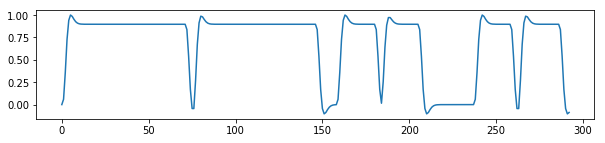

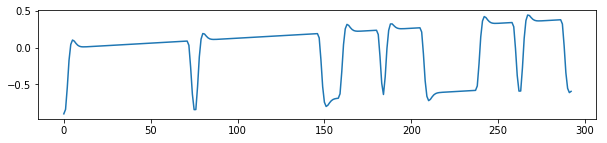

In [39]:
plot_signal_function(signal_function, regressor, fig_dim, expt_start, expt_end)

## Add a linear trend to the data

Beta for raw: 0.16, z stat: 1.06
Beta for detrended: 0.46, z stat: 5.72
Beta for raw sliced: 1.00, z stat: 639.47
Beta for detrended sliced: 1.00, z stat: 350.37


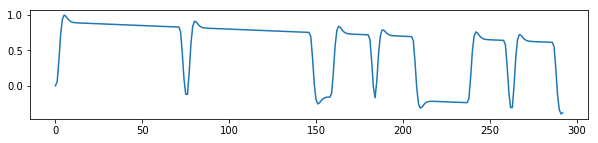

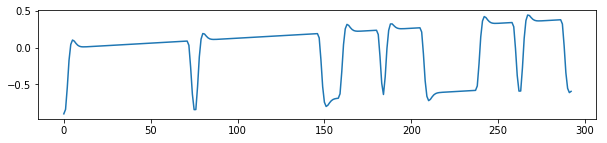

In [40]:
# Add a linear trend
signal_function_trend = signal_function.flatten() - (np.arange(len(signal_function)) * 0.001)

plot_signal_function(signal_function_trend, regressor, fig_dim, expt_start, expt_end)


## Assume a smaller response for the main experiment

Beta for raw: -0.38, z stat: -3.31
Beta for detrended: 0.04, z stat: 0.76
Beta for raw sliced: 0.33, z stat: 502118415929372788988925850943488.00
Beta for detrended sliced: 0.33, z stat: 18.86


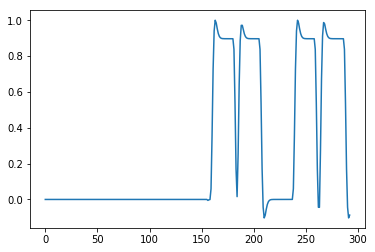

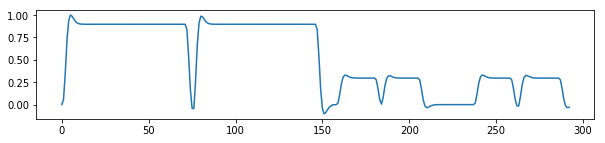

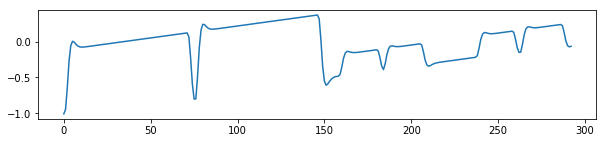

In [41]:
proportion_response = 0.33  # WHat is the scaling factor of the expected response

signal_function_weighted = np.copy(signal_function)
signal_function_weighted[expt_start:expt_end] = signal_function_weighted[expt_start:expt_end] * proportion_response

plt.figure()
plt.plot(regressor)
plot_signal_function(signal_function_weighted, regressor, fig_dim, expt_start, expt_end)

## Create pseudo-runs by cropping the data

Beta for raw: 1.00, z stat: 24354474332509412165147351318528.00
Beta for detrended: 1.00, z stat: 3092595.46


ValueError: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.

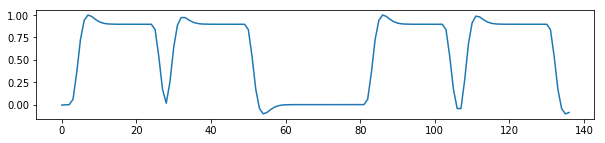

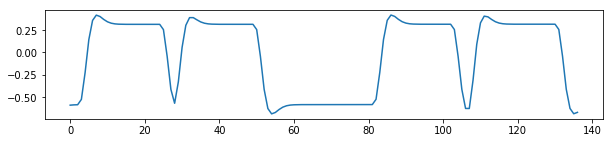

In [42]:
signal_function_cropped = signal_function[expt_start:expt_end]

plot_signal_function(signal_function_cropped, regressor[expt_start:expt_end], fig_dim, expt_start, expt_end)

## Assume voxels are not responsive to anything outside of the main experiment

Beta for raw: 1.00, z stat: 113078175894399555129782889873408.00
Beta for detrended: 0.62, z stat: 15.82
Beta for raw sliced: 1.00, z stat: 24354474332509412165147351318528.00
Beta for detrended sliced: 1.00, z stat: 72.39


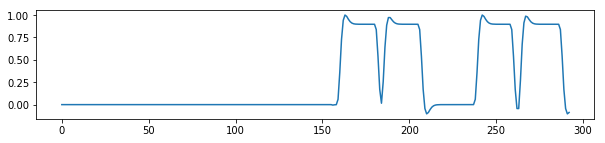

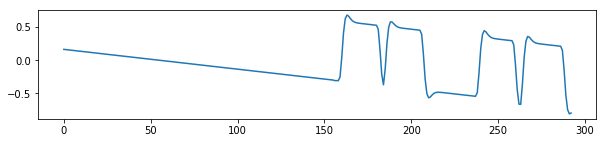

In [43]:
signal_function_zeroed = np.zeros((len(signal_function),))
signal_function_zeroed[expt_start:expt_end] = signal_function[expt_start:expt_end]

plot_signal_function(signal_function_zeroed, regressor, fig_dim, expt_start, expt_end)

## Plot voxels only responsive to the other blocks of data

Beta for raw: -0.71, z stat: -6.18
Beta for detrended: -0.16, z stat: -2.60
Beta for raw sliced: 0.00, z stat: nan
Beta for detrended sliced: -0.00, z stat: -0.02


/gpfs/milgram/apps/hpc.rhel7/software/Python/Anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide


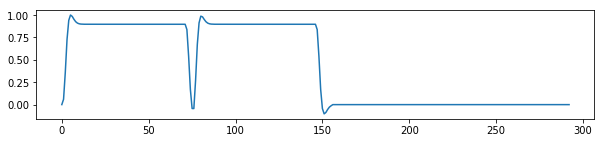

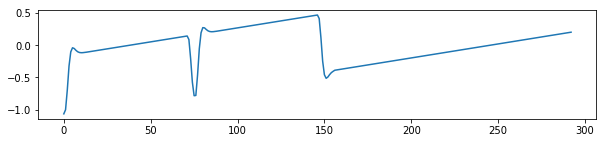

In [44]:
signal_function_async = np.zeros((len(signal_function),))
signal_function_async[:expt_start] = signal_function[:expt_start]
signal_function_async[expt_end:] = signal_function[expt_end:]

plot_signal_function(signal_function_async, regressor, fig_dim, expt_start, expt_end)